## External Data University of Twente
This notebook is designed to evaluate our model using external data sourced from the University of Twente. There exists a slight disparity between the two datasets: while ours utilizes polygons to mark cars, the external dataset employs bounding boxes, resulting in inferior car markings. Additionally, the majority of images in the external dataset were captured at a low angle, contrasting with our top-down perspective, which adversely affects performance on the external dataset.

Subsequently, we made the decision to train our model on the external dataset for a few epochs to assess potential performance improvements and evaluate its impact on our dataset's performance. For further details, refer to the notebook "test-twente-our-data.ipynb".

In [1]:
import torch
from fastai.vision.all import *
import numpy as np
from PIL import Image
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Testing our Modell on external Data

In [2]:
#function to load the masks with the cars
def mask_function(name):
    return np.load(str(name).replace("Image_Splitted", "GT_Splitted").replace(".png", ".npy"))

In [3]:
# Paths to modell and data
path = Path("/kaggle/input/tds-cars-twente/ITC_VD_Training_Testing_set")
model_path = '/kaggle/input/modell/best_model'
train_path = path/"Training/Image_Splitted"
test_path = path/"Testing/Image_Splitted"

In [4]:
#function to load the images 
def get_images(name):
    return get_image_files(train_path)+get_image_files(test_path)

In [5]:
# creating the datablock just like in our original Modell
satellite_block = DataBlock(blocks=(ImageBlock, MaskBlock(codes=["nothing", "car"])),
                            get_items=get_images,
                            splitter=GrandparentSplitter(train_name='Training', valid_name='Testing'),
                            get_y=mask_function,
                            batch_tfms=aug_transforms(size=500, max_lighting=0.3)
                            )



In [6]:
# creating a dataloader on the new external data
dataloader = satellite_block.dataloaders(path, bs=8)

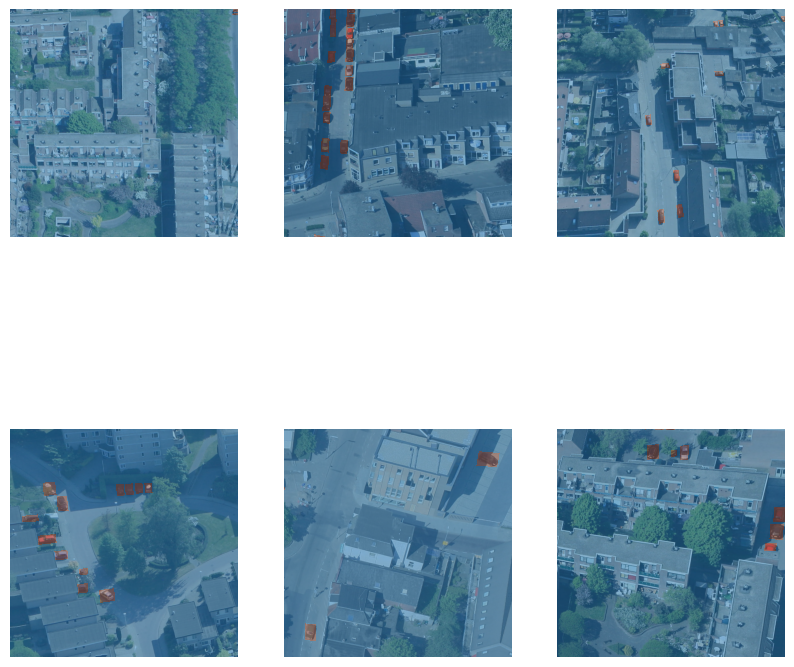

In [7]:
dataloader.show_batch(max_n=6, figsize=(10,10))

In [8]:
#create the learner
learner = unet_learner(dataloader,resnet34,metrics=Dice)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 84.7MB/s]


In [9]:
#load the learner out of the originall model
learner.load(model_path)

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


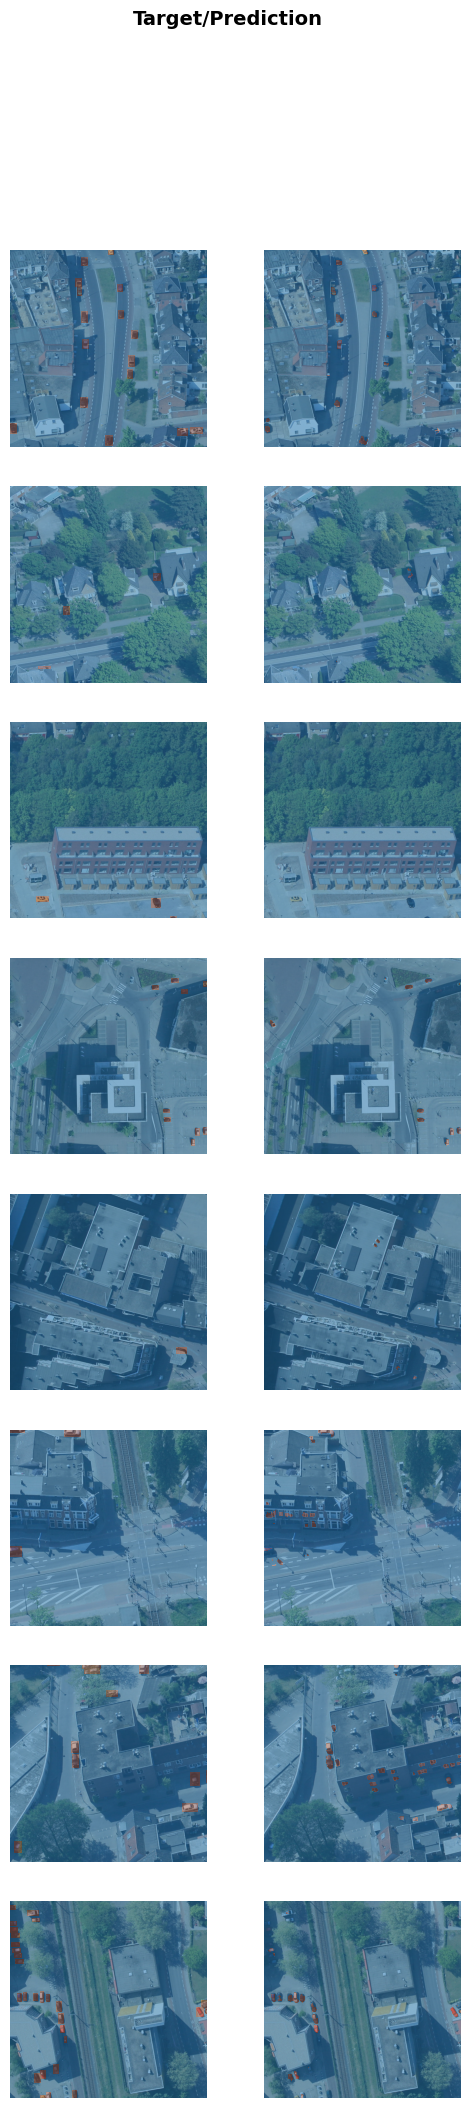

In [10]:
# show the predictions 
learner.show_results(max_n=10)

### evaluate the modell via the dice score

In [11]:
print("in-sample performance: {}".format(np.array(learner.validate(ds_idx=0)[1]))) # Dice Score

in-sample performance: 0.3671326511070369


In [12]:
print("out-of-sample performance: {}".format(np.array(learner.validate(ds_idx=1)[1]))) # Dice Score

out-of-sample performance: 0.3598055073110461


## Train Modell on Data for a few epochs
to see if this changes the performance

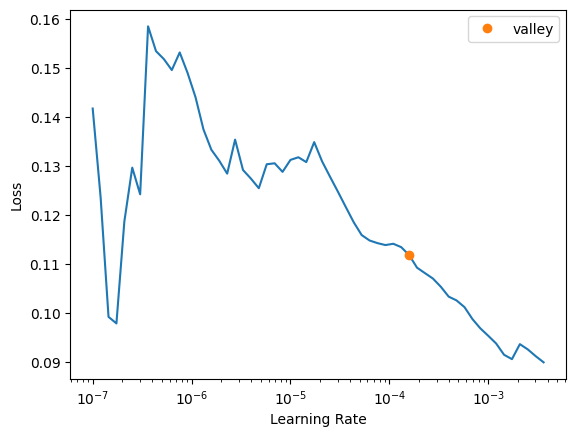

In [13]:
lr = learner.lr_find()

In [ ]:
learner.fit_one_cycle(
    10, lr_max=slice(lr.valley/10,lr.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=10, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_trained_model')]
         )

epoch,train_loss,valid_loss,dice,time
0,0.027372,0.025403,0.707473,03:54
1,0.029074,0.032186,0.565099,03:54
2,0.021391,0.019311,0.775085,03:54
3,0.018268,0.018835,0.780223,03:54
4,0.016179,0.016534,0.783024,03:54
5,0.015142,0.015387,0.818000,03:53


Better model found at epoch 0 with dice value: 0.707473260521539.
Better model found at epoch 2 with dice value: 0.7750851747558988.
Better model found at epoch 3 with dice value: 0.7802229894558651.
Better model found at epoch 4 with dice value: 0.7830241476835852.
Better model found at epoch 5 with dice value: 0.8179997372085298.


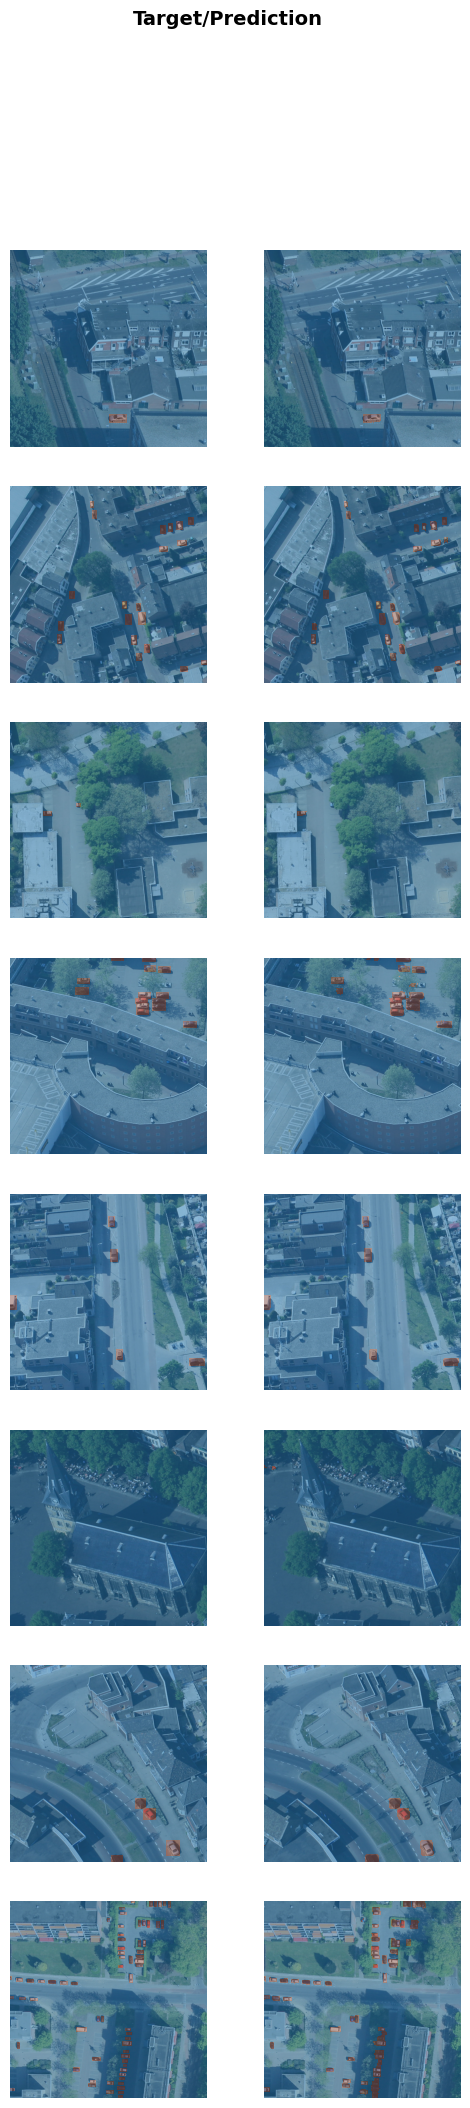

In [17]:
# show predictions after retraining
learner.show_results(max_n=10)

### evaluate the modell via the dice score
as you can see the performance gets a lot better after just 5 extra epochs of training

In [18]:
print("in-sample performance: {}".format(np.array(learner.validate(ds_idx=0)[1]))) # Dice Score

in-sample performance: 0.8755453075557902


In [19]:
print("out-of-sample performance: {}".format(np.array(learner.validate(ds_idx=1)[1]))) # Dice Score

out-of-sample performance: 0.8408214977956362
